In [36]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

print(train.shape, val.shape, test.shape)

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

(47520, 41) (11880, 41) (14358, 40)


In [2]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [3]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,...,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,7,27,2011
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,...,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,23,3
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011,3,7,1
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,...,shallow well,shallow well,groundwater,other,other,non functional,2011,7,31,2011
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,...,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2011,3,10,2011


In [4]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    DecisionTreeClassifier(max_depth=20, random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv', index=False)

Validation Accuracy 0.7712121212121212


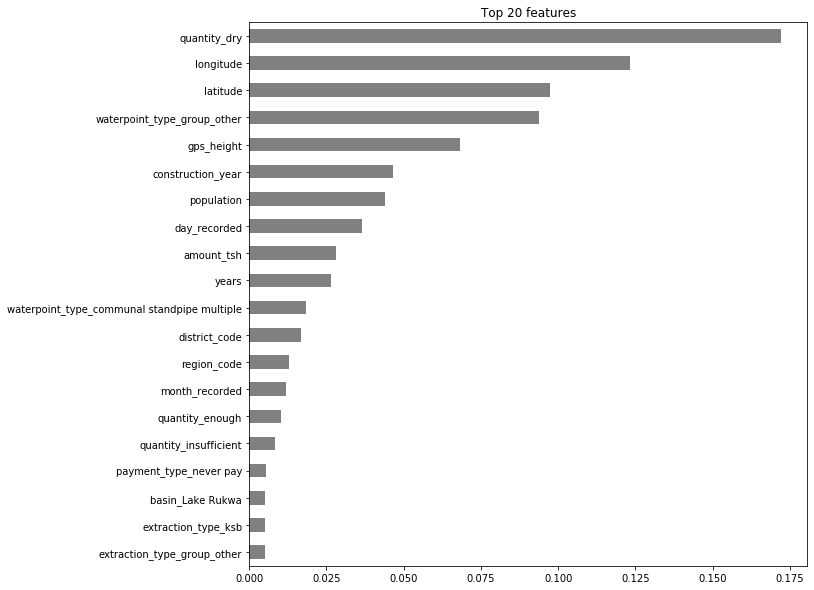

In [5]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [6]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

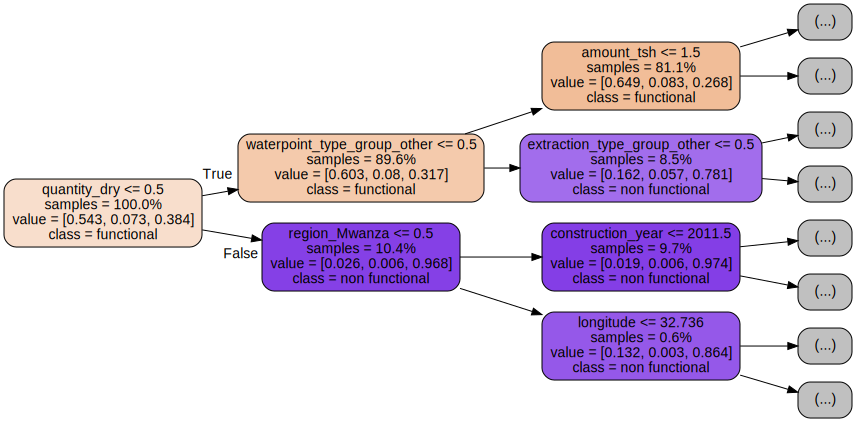

In [7]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=feature_names, 
                           class_names=tree.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

In [8]:
# TODO

from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-04.csv', index=False)

Validation Accuracy 0.8087542087542088


In [9]:
encoder = pipeline.named_steps['onehotencoder']
encoded_shape = encoder.transform(X_train).shape
print(encoded_shape, X_train.shape)

(47520, 183) (47520, 33)


In [10]:
# TODO

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test

In [11]:
X_train.shape

(47520, 40)

In [18]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=300,
                           min_samples_split=3,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-rf-ordinal.csv', index=False)

Train Accuracy 0.9974747474747475
Validation Accuracy 0.8164141414141414


In [14]:
encoder = pipeline.named_steps['ordinalencoder']
X_train_encoded = encoder.transform(X_train)
print(X_train_encoded.shape, X_train.shape)

(47520, 40) (47520, 40)


In [15]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,...,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2011,7,27,2011
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3,23,3
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,...,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2011,3,7,1
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,...,enough,shallow well,shallow well,groundwater,other,other,2011,7,31,2011
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,...,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,2011,3,10,2011


In [16]:
X_train_encoded.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
43360,0.0,1,NaN,1,33.542898,-9.174777,1,0,1,1,...,1,1,1,1,1,1,2011,7,27,2011
7263,500.0,2,2049.0,2,34.665760,-9.308548,2,0,2,2,...,2,1,1,1,1,1,2011,3,23,3
2486,25.0,3,290.0,3,38.238568,-6.179919,3,0,3,3,...,1,2,2,1,2,2,2011,3,7,1
313,0.0,4,NaN,4,30.716727,-1.289055,4,0,4,4,...,2,2,2,1,3,3,2011,7,31,2011
52726,0.0,5,NaN,5,35.389331,-6.399942,5,0,5,5,...,2,3,3,1,1,1,2011,3,10,2011


In [19]:
np.random.randint(low=0, high=100, size=10)

array([76, 59,  6, 64, 72, 52, 18, 85, 86, 84])

In [20]:
putts = pd.DataFrame(
    columns=['distance', 'tries', 'successes'], 
    data = [[2, 1443, 1346],
            [3, 694, 577],
            [4, 455, 337],
            [5, 353, 208],
            [6, 272, 149],
            [7, 256, 136],
            [8, 240, 111],
            [9, 217, 69],
            [10, 200, 67],
            [11, 237, 75],
            [12, 202, 52],
            [13, 192, 46],
            [14, 174, 54],
            [15, 167, 28],
            [16, 201, 27],
            [17, 195, 31],
            [18, 191, 33],
            [19, 147, 20],
            [20, 152, 24]]
)

putts['rate of success'] = putts['successes'] / putts['tries']
putts_X = putts[['distance']]
putts_y = putts['rate of success']

In [21]:
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def putt_trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(putts_X, putts_y)
        ax = putts.plot('distance', 'rate of success', kind='scatter', title=name)
        ax.step(putts_X, model.predict(putts_X), where='mid')
        plt.show()
        
interact(putt_trees, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

In [22]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)
def diy_bagging(max_depth=1, n_estimators=1):
    y_preds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = putts.sample(n=len(putts), replace=True).sort_values(by='distance')
        bootstrap_X = bootstrap_sample[['distance']]
        bootstrap_y = bootstrap_sample['rate of success']
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(bootstrap_X, bootstrap_y)
        y_pred = tree.predict(bootstrap_X)
        y_preds.append(y_pred)
        ax = bootstrap_sample.plot('distance', 'rate of success', kind='scatter', title=title)
        ax.step(bootstrap_X, y_pred, where='mid')
        plt.show()
        
    ensembled = np.vstack(y_preds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    ax = putts.plot('distance', 'rate of success', kind='scatter', title=title)
    ax.step(putts_X, ensembled, where='mid')
    plt.show()
    
interact(diy_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

In [24]:
def viz2D(fitted_model, X, feature1, feature2, num=100, title=''):
    """
    Visualize model predictions as a 2D heatmap
    For regression or binary classification models, fitted on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    Returns
    -------
    predictions: numpy array, predictions/predicted probabilities at each grid point
    
    References
    ----------
    https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
    https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
    """
    x1 = np.linspace(X[feature1].min(), X[feature1].max(), num)
    x2 = np.linspace(X[feature2].min(), X[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,0]
    else:
        predicted = fitted_model.predict(X)
    
    plt.imshow(predicted.reshape(num, num), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    return predicted

In [25]:
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'longitude'
feature2 = 'latitude'

from sklearn.linear_model import LogisticRegression

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        viz2D(model, X, feature1, feature2, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

In [26]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)

# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders

feature1 = 'longitude'
feature2 = 'latitude'

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train.sample(n=len(train), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = viz2D(tree, X, feature1, feature2, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    plt.imshow(ensembled.reshape(100, 100), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

In [27]:
feature = 'quantity'

In [28]:
X_train[feature].value_counts()

enough          26567
insufficient    12153
dry              4921
seasonal         3244
unknown           635
Name: quantity, dtype: int64

In [29]:
X_train[feature].value_counts(normalize=True)

enough          0.559070
insufficient    0.255745
dry             0.103556
seasonal        0.068266
unknown         0.013363
Name: quantity, dtype: float64

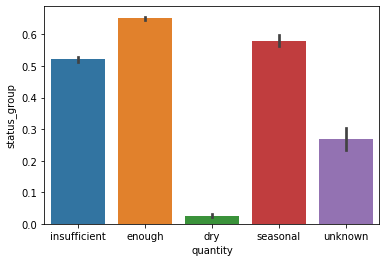

In [30]:
sns.barplot(x=train[feature], 
            y=train['status_group']=='functional');

In [31]:
X_train[feature].head(15)

43360    insufficient
7263           enough
2486     insufficient
313            enough
52726          enough
8558     insufficient
2559     insufficient
54735          enough
25763          enough
44540          enough
28603             dry
4372     insufficient
30666    insufficient
6431           enough
57420    insufficient
Name: quantity, dtype: object

In [32]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head(15)

5 columns


,quantity_insufficient,quantity_enough,quantity_dry,quantity_seasonal,quantity_unknown
43360,1,0,0,0,0
7263,0,1,0,0,0
2486,1,0,0,0,0
313,0,1,0,0,0
52726,0,1,0,0,0
8558,1,0,0,0,0
2559,1,0,0,0,0
54735,0,1,0,0,0
25763,0,1,0,0,0
44540,0,1,0,0,0


In [33]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(15)

1 column, 5 unique values


,quantity
43360,1
7263,2
2486,1
313,2
52726,2
8558,1
2559,1
54735,2
25763,2
44540,2
